In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [2]:
#Load the balanced dataset 
dir1 = 'subsample_data'
data = pd.read_csv(dir1,header=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33,35,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Load the imbalanced dataset(ratio 1:16) for test
dir2 = 'test.csv'
test = pd.read_csv(dir2,header=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,26,43,46,62,63,64,65,66,67,68,69,70,71,74,75,77,80,81,82,174,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#Split the balanced datset into the targeted feature and predictive features
target = data['Target']
features = data.drop('Target', axis=1)

#Extract only numeric features from data
numerics = features._get_numeric_data()

#Extract categorical features and store the list of names of categorical features
categoricals = features.select_dtypes(include='object')

## Task 1: Identify Features 

In [11]:
#Check the number of missing values of numeric features
num = numerics.isnull().sum()
num

#Check the number of missing values of categorical features
categ = categoricals.isnull().sum()
categ

Unnamed: 0                                                             0
Physician_License_State_code2                                       9877
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           9941
Recipient_State                                                       11
Recipient_Country                                                      7
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           1795
Form_of_Payment_or_Transfer_of_Value                                   0
Associated_Drug_or_Biological_NDC_4                                 9898
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           9849
Covered_or_Noncovered_Indicator_3                                   9533
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5            9941
Physician_Specialty                                                 4802
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4            9849
Date_of_Payment                                    

In [6]:
#Check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 67 columns):
Unnamed: 0                                                          10000 non-null object
Unnamed: 1                                                          10000 non-null int64
Physician_License_State_code2                                       123 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           59 non-null object
Recipient_State                                                     9989 non-null object
Recipient_Country                                                   9993 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           8205 non-null object
Form_of_Payment_or_Transfer_of_Value                                10000 non-null object
Associated_Drug_or_Biological_NDC_4                                 102 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           151 non-null object
Cover

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


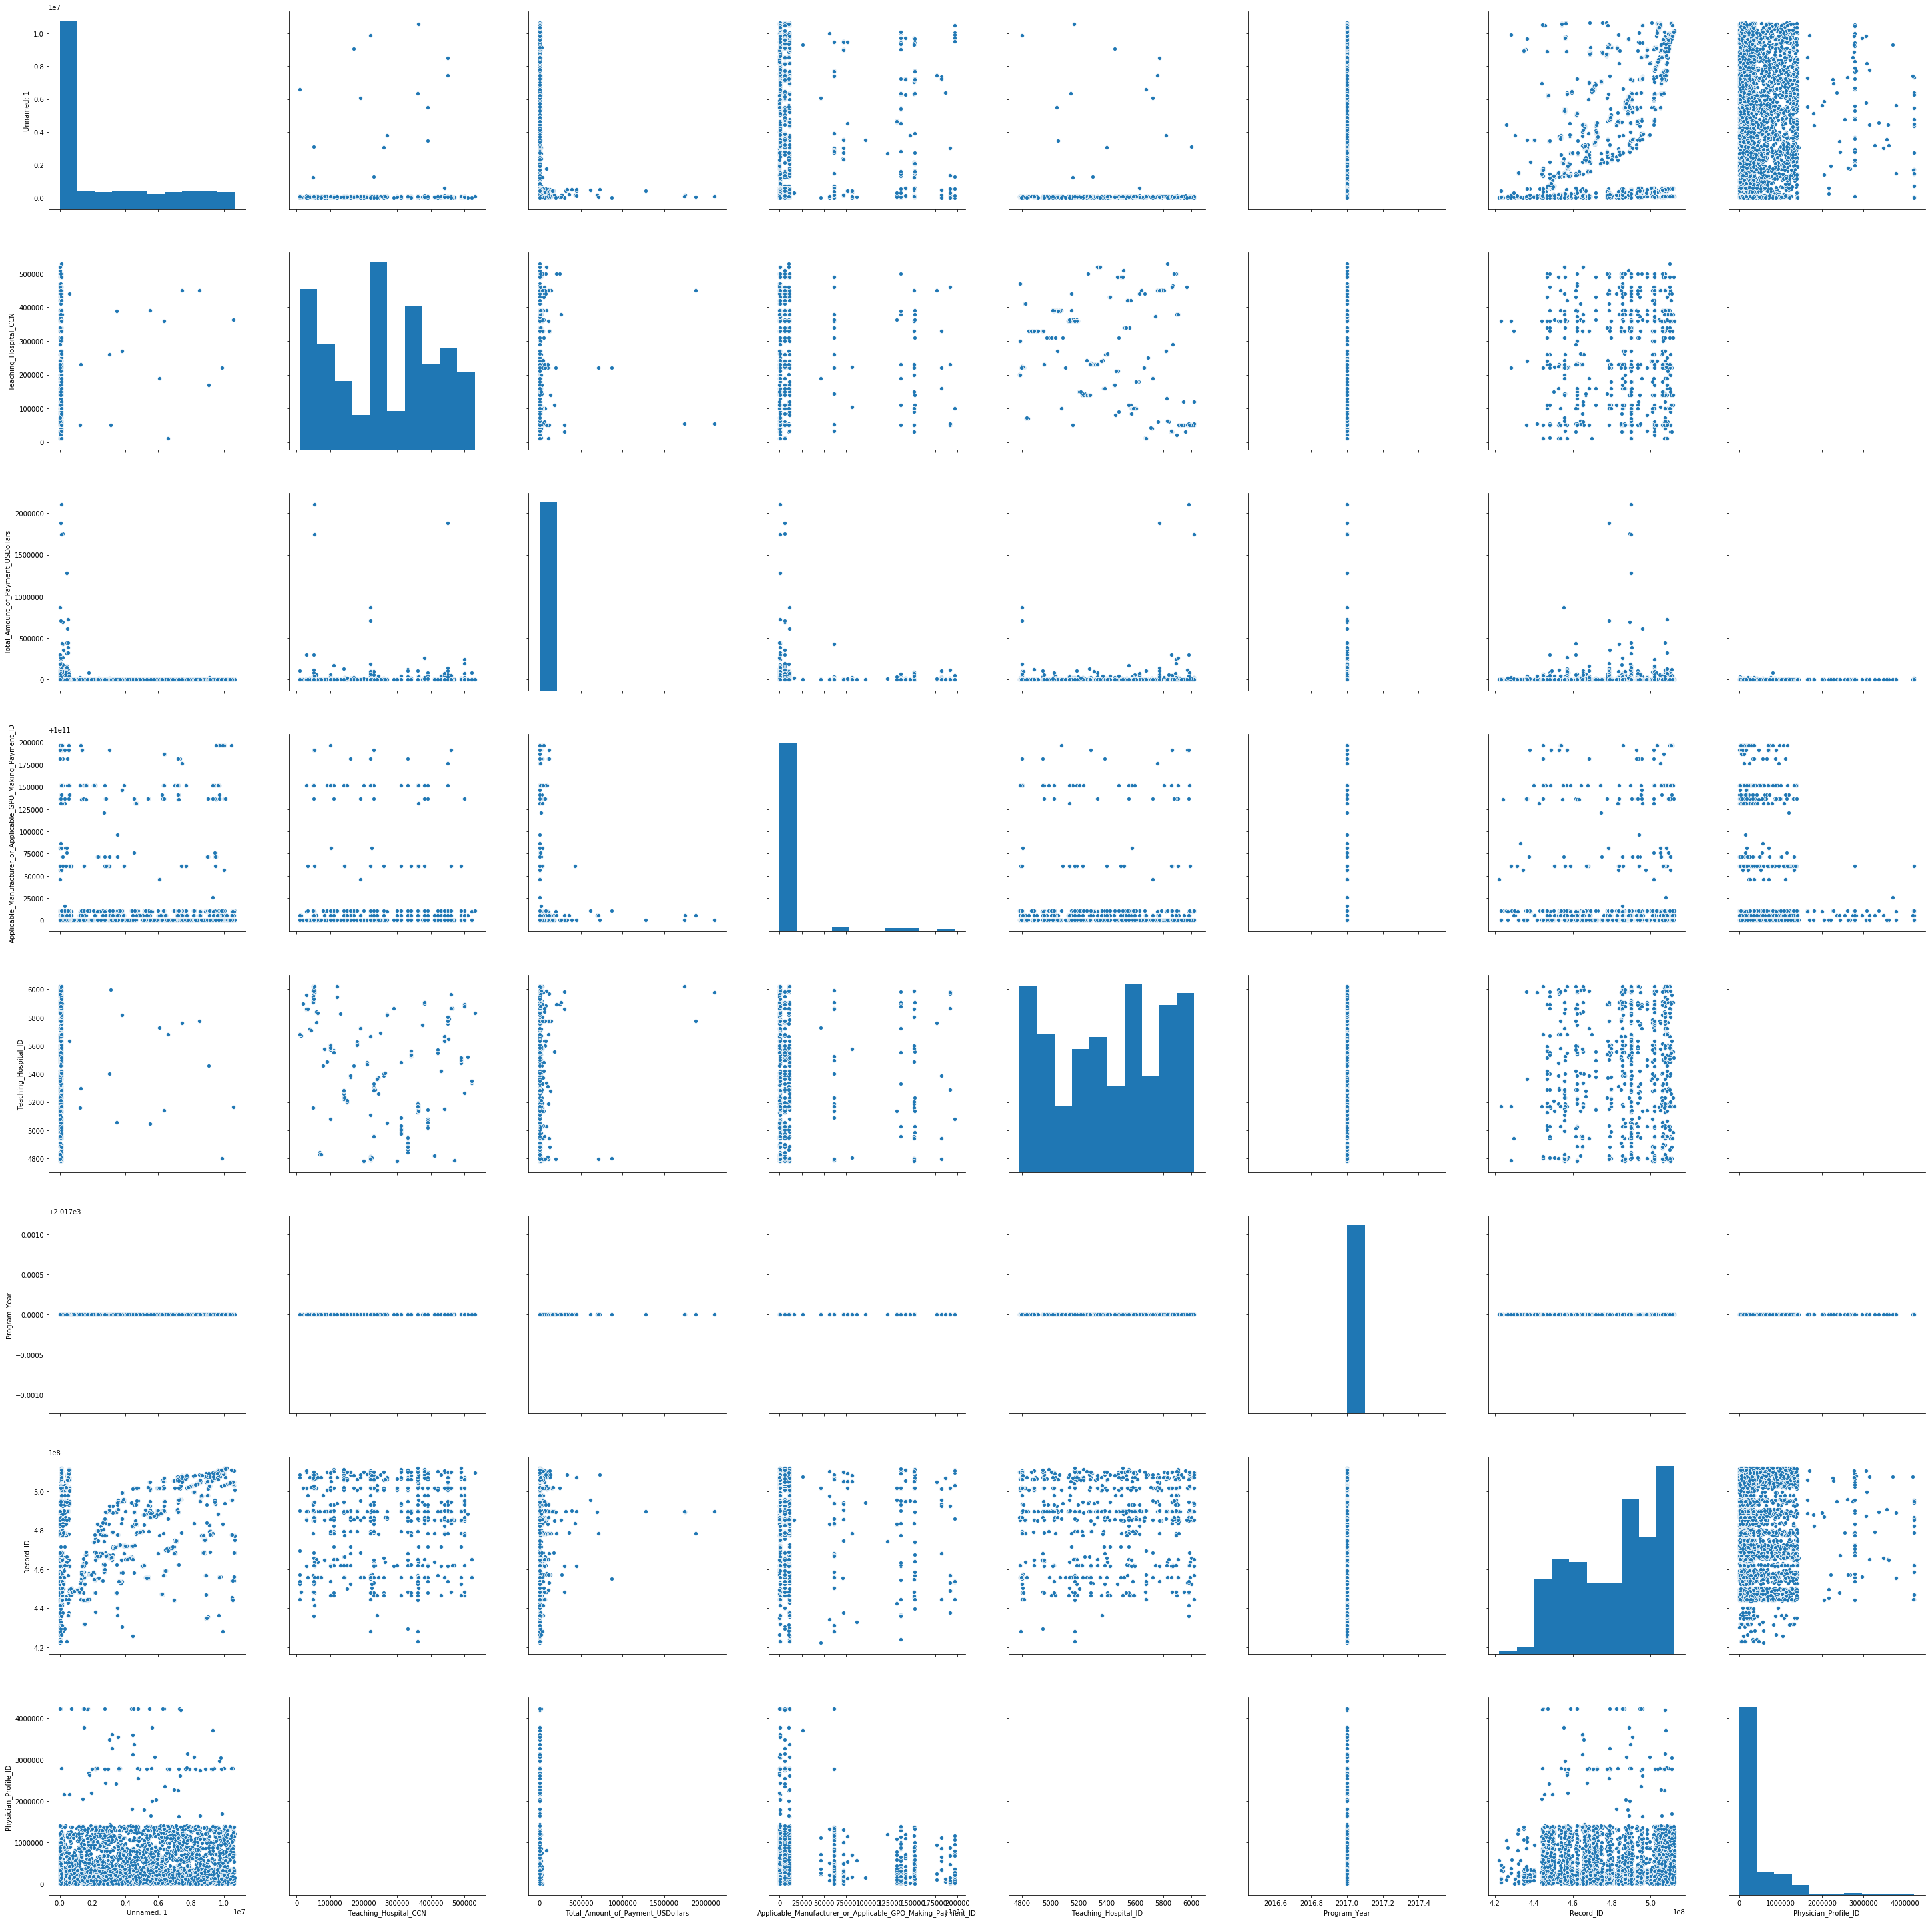

In [7]:
#Create a pairplot for numeric features to see how they are distributed
sns.pairplot(numerics,size=5)

## Preprocessing & Data Cleansing (For Balanced Data)

In [12]:
#Extract columns which have fewer than 5000 nulls
num_name = []
for i in range(len(num)):
    if(num[i-1] < 5000):
        num_name.append(num.index.tolist()[i-1])
    else:
        continue
num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']

#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
temp = data[num_name]
num_temp = temp[['Total_Amount_of_Payment_USDollars']]
num_name = list(num_temp)

In [14]:
#Store the list of names of numeric features
numeric_features = list(numerics)

#Store the list of names of categorical features
categorical_features = list(categoricals)

In [15]:
#Extract columns which have fewer than 5000 nulls
categ_name = []
for i in range(len(categ)):
    if(categ[i-1] < 5000):
        categ_name.append(categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
categ_temp = data[categ_name]
categ_name = list(categ_temp)

In [17]:
#Concatenate num_temp and categ_temp
new = pd.concat([num_temp,categ_temp],axis=1)

In [21]:
#Remove meaningless features
above_98 = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
            'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1','Recipient_Zip_Code']
new_remove = ['Date_of_Payment']
num_name = ['Total_Amount_of_Payment_USDollars']
categ_name_copy = deepcopy(categ_name)
remove_list = above_98 + new_remove + rec_details
for a in remove_list:
    if a in categ_name_copy:
        categ_name_copy.remove(a)

## Preprocessing & Data Cleansing (For Imbalanced Data)

In [25]:
#Split the balanced datset into the targeted feature and predictive features
imb_target = test['Target']
imb_features = test.drop('Target', axis=1)

#Extract only numeric features from data
imb_numerics = imb_features._get_numeric_data()

#Extract categorical features and store the list of names of categorical features
imb_categoricals = imb_features.select_dtypes(include='object')

In [26]:
#Check the number of missing values of numeric features
imb_num = imb_numerics.isnull().sum()

#Check the number of missing values of categorical features
imb_categ = imb_categoricals.isnull().sum()

In [27]:
#Extract columns which have fewer than 5000 nulls
imb_num_name = []
for i in range(len(imb_num)):
    if(imb_num[i-1] < 5000):
        imb_num_name.append(imb_num.index.tolist()[i-1])
    else:
        continue
imb_num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']

#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
imb_temp = test[imb_num_name]
imb_num_temp = imb_temp[['Total_Amount_of_Payment_USDollars']]
imb_num_name = list(imb_num_temp)

In [28]:
#Store the list of names of numeric features
imb_numeric_features = list(imb_numerics)

#Store the list of names of categorical features
imb_categorical_features = list(imb_categoricals)

In [29]:
#Extract columns which have fewer than 5000 nulls
imb_categ_name = []
for i in range(len(imb_categ)):
    if(imb_categ[i-1] < 5000):
        imb_categ_name.append(imb_categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
imb_categ_temp = test[imb_categ_name]
imb_categ_name = list(imb_categ_temp)

In [30]:
#Concatenate num_temp and categ_temp
new_new = pd.concat([imb_num_temp,imb_categ_temp],axis=1)

## Task 2: Baseline Model (Logistic Regression)

In [32]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=0.01))])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)


#Cross validation 
scores = cross_val_score(clf,X_train, y_train, cv=10)
scores = sum(scores) / float(len(scores))
print("Baseline Model Cross Validation Score:")
print(scores)



Baseline Model Cross Validation Score:
0.858


## Task 3: Feature Engineering

## Task 4: Any model

**Logistic Regression with GridSearch**

In [39]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

param_grid = {'classifier__C': [0.01,0.1, 1, 10, 100]}

logistic_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
logistic_grid.fit(X_train, y_train)

print("best mean cross-validation score of Logistic Regression: {:.3f}".format(logistic_grid.best_score_))
print("best parameters of Logistic Regression: {}".format(logistic_grid.best_params_))
print("test-set score of Logistic Regression: {:.3f}".format(logistic_grid.score(X_test, y_test)))
print("")

logistic = LogisticRegression(C=logistic_grid.best_params_['classifier__C'])
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', logistic)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Logistic Regression: 0.899
best parameters of Logistic Regression: {'classifier__C': 100}
test-set score of Logistic Regression: 0.885

Confusion Metrix:
[[1312  188]
 [ 158 1342]]

ROC AUC score:
0.8846666666666667

Precision Score:
0.8771241830065359

Recall Score:
0.8846666666666667


In [54]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier(alpha=100))])

clf.fit(features,target)




Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001))])

In [55]:
#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8050 1394]
 [  66  490]]

ROC AUC score:
0.8668440089097718

Precision Score:
0.23581153523041437

Recall Score:
0.854


**Ridge Regression with GridSearch**

In [41]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

param_grid = {'classifier__alpha': [0.01,0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
ridge_grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
print("")

ridge = RidgeClassifier(alpha=ridge_grid.best_params_['classifier__alpha'])
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ridge)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Ridge Regression: 0.873
best parameters of Ridge Regression: {'classifier__alpha': 0.01}
test-set score of Ridge Regression: 0.872

Confusion Metrix:
[[1299  201]
 [ 183 1317]]

ROC AUC score:
0.8720000000000001

Precision Score:
0.8675889328063241


In [50]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier(alpha=0.01))])

clf.fit(features,target)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...tercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001))])

In [51]:
#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8166 1278]
 [  65  491]]

ROC AUC score:
0.8738847549660399

Precision Score:
0.25160962174296736

Recall Score:
0.8657


**Random Forest with GridSearch**

In [43]:
#Split the dataset into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3,shuffle=True)

#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

param_grid = {'classifier__n_estimators': range(50, 300, 50),
             'classifier__max_depth' : range(1,10)}

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=9,n_estimators=200,random_state=0))])

grid = GridSearchCV(clf, param_grid,cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Score', grid.best_score_)
print('Best params',grid.best_params_)


rfc = RandomForestClassifier(n_estimators=grid.best_params_['classifier__n_estimators'],
                               max_depth=grid.best_params_['classifier__max_depth'],random_state=0)
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rfc)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

Score 0.9703885714285715
Best params {'classifier__max_depth': 9, 'classifier__n_estimators': 150}
[[1366  134]
 [  74 1426]]
0.9306666666666666

Precision Score:
0.9141025641025641

Recall Score:
0.9306666666666666


In [56]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

param_grid = {'classifier__n_estimators': range(50, 300, 50),
             'classifier__max_depth' : range(1,10)}

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=9,n_estimators=150,random_state=0))])

clf.fit(features,target)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose...mators=150, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [57]:
#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8525  919]
 [  36  520]]

ROC AUC score:
0.9189706684461832

Precision Score:
0.3415645137260587

Recall Score:
0.9045


**XGBoost with GridSearch**

In [58]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

params = {
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]
        }
grid = GridSearchCV(clf, param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(grid.best_score_))
print("best parameters of Ridge Regression: {}".format(grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(grid.score(X_test, y_test)))
print("")

XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
                        subsample=grid.best_params_['classifier__subsample'],
                        max_depth=grid.best_params_['classifier__max_depth'])

final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',XGBoost)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Ridge Regression: 0.942
best parameters of Ridge Regression: {'classifier__gamma': 1.5, 'classifier__max_depth': 5, 'classifier__subsample': 1.0}
test-set score of Ridge Regression: 0.943

Confusion Metrix:
[[1388  112]
 [  59 1441]]

ROC AUC score:
0.9430000000000001

Precision Score:
0.9278815196394076

Recall Score:
0.943


In [ ]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

In [ ]:
#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

## Task 5: Feature Selections

In [59]:
np.argsort(np.absolute(final_pipe.named_steps['classifier'].feature_importances_))

array([128,  69,  68,  67,  65, 125,  62, 122, 123,  58,  57,  56,  55,
       107,  53,  50,  49,  47,  70,  71,  74, 120, 104, 110, 112, 115,
       100,  94,  92,  89,  44,  88, 117, 118,  84,  82,  81,  80,  79,
        78, 116,  43,  54,  41,  22,  20,  19,  18,  17,  15,  14,  13,
        12,  10,   9,   8,   5,   4,   3,   2,   1,  23,  27, 109,  32,
        38,  28,  34, 124,  31,  39,  30,  72,  42,  35,  46,   7,  48,
        26,  45,  52,  16,  37,  33,  51,  40,  90, 121,  97,  99, 105,
        21,  36,  11,  66, 119,  76,   6,  96,  24,  25,  98, 106,  61,
        75,  91,  73,  93,  95,  63,  86,  29,  59,  85,  87, 102, 114,
       108, 111, 103, 127, 113, 101,  77, 126,  83,  60,  64,   0])

In [61]:
final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[128]

IndexError: index 128 is out of bounds for axis 0 with size 128

## Task 6: An explainable model

0.748


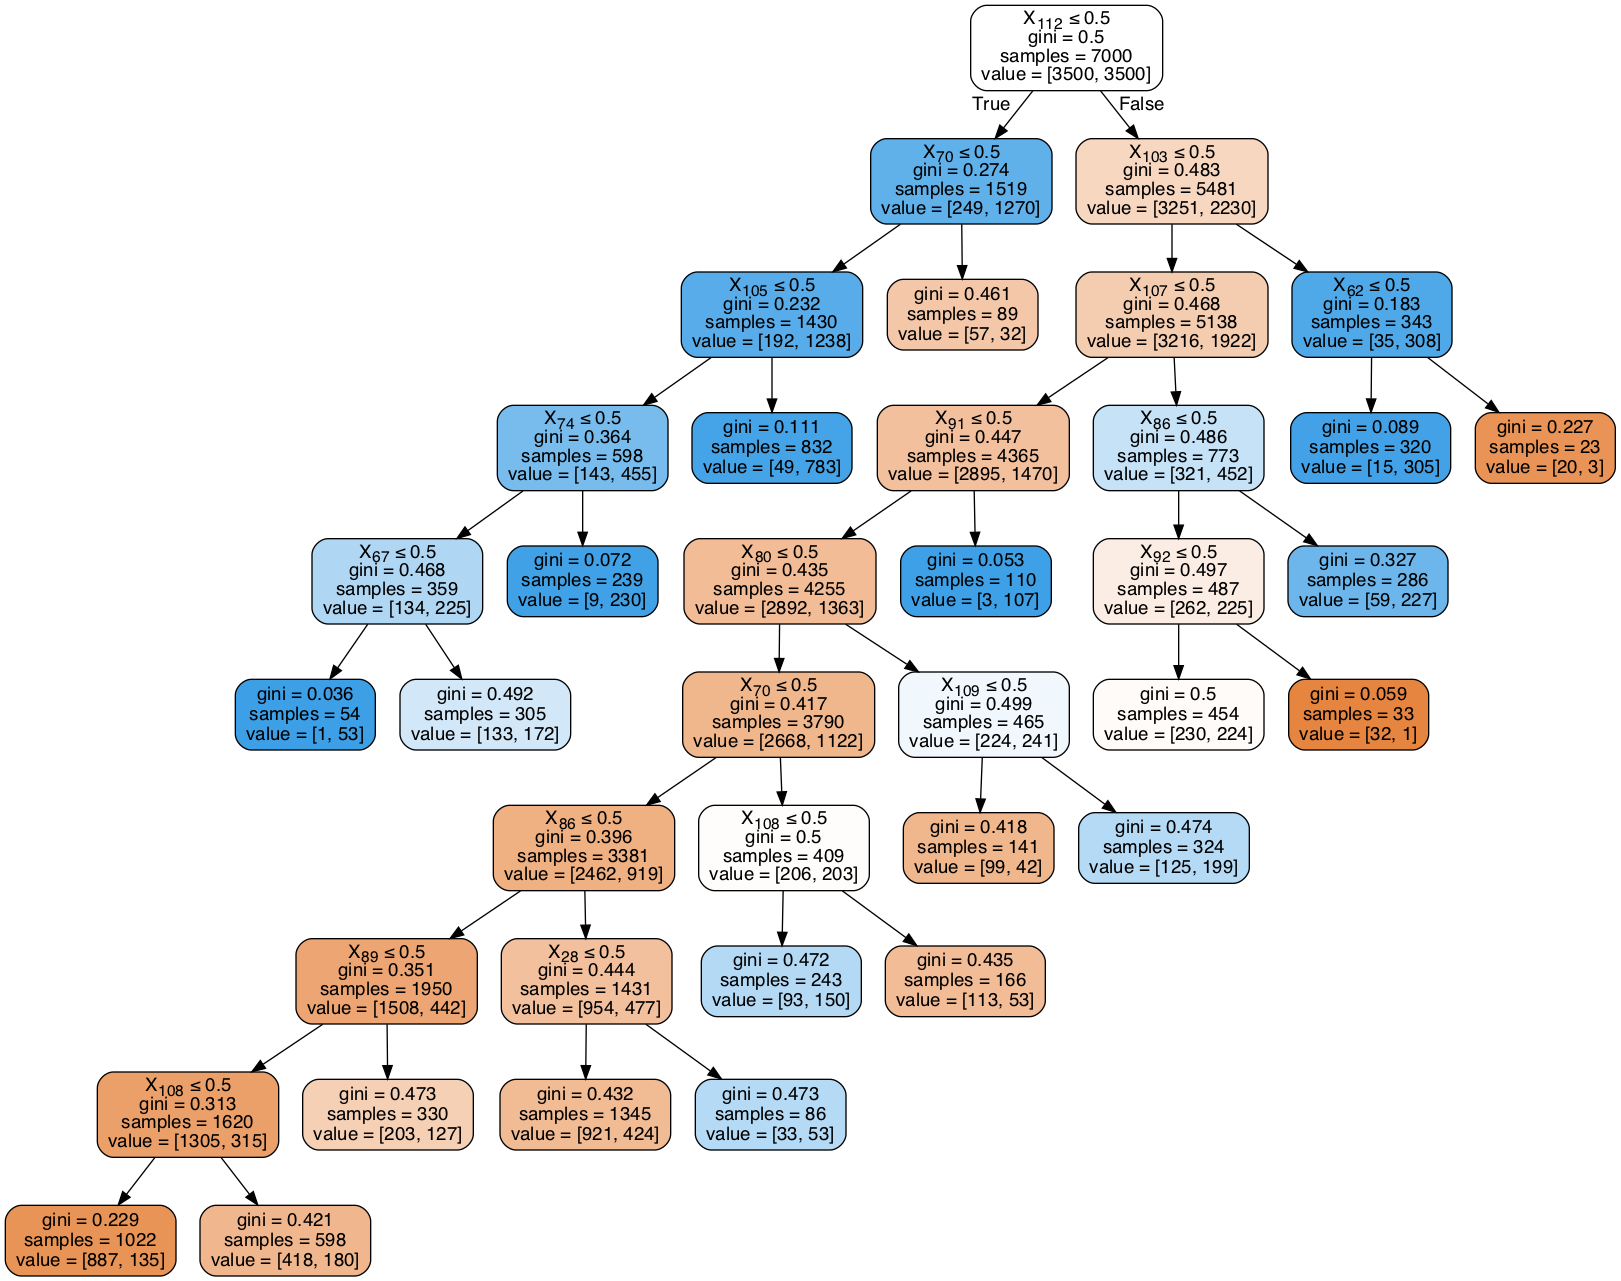

In [66]:
#Package for visualizing the decision tree
!pip install pydotplus

# Training a decision tree 

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3,shuffle=True)

# TO be replaced by the best features of the xgboost model
cat_names = ['Recipient_State','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
            'Related_Product_Indicator','Delay_in_Publication_Indicator','Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
            'Covered_or_Noncovered_Indicator_1']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_names)])

X_train_processed = preprocessor.fit_transform(X_train[cat_names])
dtree=DecisionTreeClassifier(max_leaf_nodes=20)
dtree.fit(X_train_processed,y_train)

X_test_processed = preprocessor.transform(X_test[cat_names])
print(dtree.score(X_test_processed,y_test))

# Plotting the decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())